In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab
from matplotlib.animation import FuncAnimation

In [2]:
n = 64
N = n * n
dx = (10 - (-10))/n

e0 = np.zeros((N,1))
e1 = np.ones((N,1))
e2 = np.copy(e1)
e4 = np.copy(e0)

for i in range(1,n+1):
    e2[n*i-1] = 0
    e4[n*i-1] = 1

e3 = np.zeros_like(e2)
e3[1:N] = e2[0:N-1]
e3[0] = e2[N-1]

e5 = np.zeros_like(e4)
e5[1:N] = e4[0:N-1]
e5[0] = e4[N-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
e2.flatten(), -4 * e1.flatten(), e3.flatten(), e4.flatten(), e1.flatten(), e1.flatten()]

offsets = [-(N-n), -n, -n+1, -1, 0, 1, n-1, n, (N-n)]
A = (spdiags(diagonals, offsets, N, N)).toarray()
A[0,0] = 2
A /= dx**2

eb = np.ones((N,1))

diag = [eb.flatten(),-eb.flatten(),eb.flatten(),-eb.flatten()]
offsets = [-(N-n),-n,n,N-n]
B = (spdiags(diag, offsets, N, N)/(2*dx)).toarray()

ec = np.ones((N,1))

ec2 = np.zeros((N,1))
for i in range(1,n+1):
    ec2[i*n-1] = 1
    ec[i*n-1] = 0

ec1 = np.zeros_like(ec)
ec1[1:N] = ec[0:N-1]
ec1[0] = ec[n-1]

ec3 = np.zeros_like(ec2)
ec3[1:N] = ec2[0:N-1]
ec3[0] = ec2[n-1]

diag = [ec3.flatten(),-ec.flatten(),ec1.flatten(),-ec2.flatten()]
offsets = [-n+1,-1,1,n-1]
C = (spdiags(diag, offsets, N, N)/(2*dx)).toarray()


In [3]:
tspan = np.arange(0,4.5,0.5)
Lx, Ly = 20, 20
nx, ny = 64, 64
k = 1
nu = 0.001
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(-X**2 - Y**2/20)
wt2 = w.reshape(N)

kx = (2*np.pi/Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = (2*np.pi/Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0] = 1e-6
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

Elapsed time: 0.88 seconds


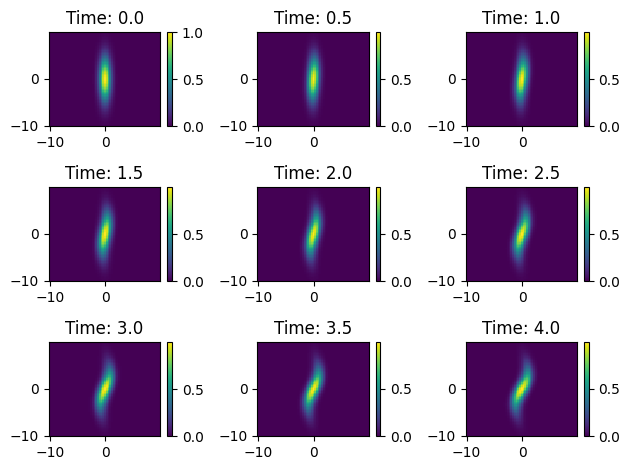

In [4]:
def spc_rhs(t, wt2, nx, ny, N, K, A, B, C, nu):
    wt = wt2.reshape((nx, ny))
    wt_hat = fft2(wt)
    psit_hat = -wt_hat / K
    psi = np.real(ifft2(psit_hat)).reshape(N)
    rhs = nu * A.dot(wt2) - B.dot(psi) * C.dot(wt2) + C.dot(psi) * B.dot(wt2)
    return rhs

start_time = time.time() 

wtsol = solve_ivp(
    spc_rhs, [tspan[0], tspan[-1]], wt2, t_eval=tspan,
    args=(nx, ny, N, K, A, B, C, nu), method='RK45'
)

A1 = wtsol.y

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

for j, t in enumerate(tspan):
    w = A1[:,j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
cax = ax.pcolor(x, y, A1[:, 0].reshape((nx, ny)), shading='auto')
cb = plt.colorbar(cax, ax=ax)
title = ax.set_title("Time: 0.00")

def update(frame):
    w = A1[:, frame].reshape((nx, ny))
    cax.set_array(w.ravel())
    title.set_text(f"Time: {tspan[frame]:.2f}")
    return cax, title

ani = FuncAnimation(
    fig, update, frames=len(tspan), interval=200, blit=False
)

ani.save("dynamic_animation.gif", writer="imagemagick", fps=5)  # Adjust fps for speed
plt.close(fig)

print("Animated GIF saved as dynamic_animation.gif")

Elapsed time: 31.61 seconds


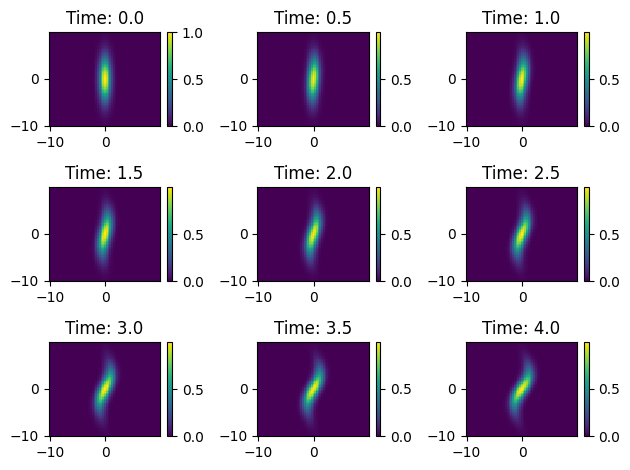

In [102]:
def spc_rhs2(t, wt2, A, B, C, nu):

    psi = np.linalg.solve(A, wt2)
    rhs = nu * A.dot(wt2) - B.dot(psi) * C.dot(wt2) + C.dot(psi) * B.dot(wt2)
    return rhs

start_time = time.time()

wtsol = solve_ivp(
    spc_rhs2, [tspan[0], tspan[-1]], wt2, t_eval=tspan,
    args=(A, B, C, nu), method='RK45'
)

A2 = wtsol.y

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

for j, t in enumerate(tspan):
    w = A2[:N,j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

Elapsed time: 63.55 seconds


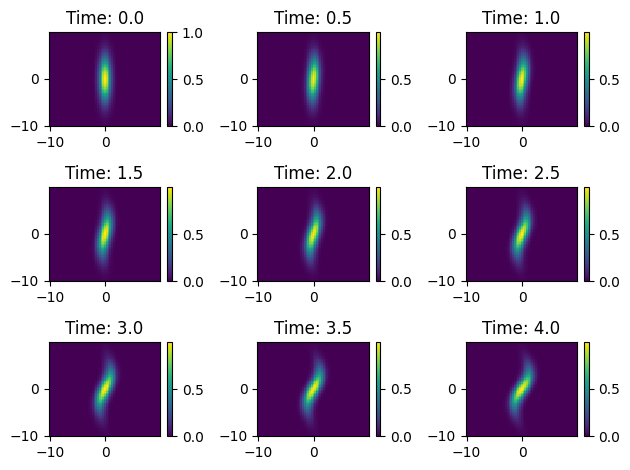

In [105]:
def spc_rhs3(t, wt2, A, B, C, nu):

    P, L, U = lu(A)

    Pb = np.dot(P, wt2)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    rhs = nu * A.dot(wt2) - B.dot(psi) * C.dot(wt2) + C.dot(psi) * B.dot(wt2)
    return rhs

start_time = time.time()

wtsol = solve_ivp(
    spc_rhs3, [tspan[0], tspan[-1]], wt2, t_eval=tspan,
    args=(A, B, C, nu), method='RK45'
)

A3 = wtsol.y


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

for j, t in enumerate(tspan):
    w = A3[:N,j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [7]:
def spc_rhs4(t, wt2, A, B, C, nu):
    psi, exitCode = gmres(A, wt2)
    
    rhs = nu * A.dot(wt2) - B.dot(psi) * C.dot(wt2) + C.dot(psi) * B.dot(wt2)
    return rhs

start_time = time.time()

wtsol = solve_ivp(
    spc_rhs4, [tspan[0], tspan[-1]], wt2, t_eval=tspan,
    args=(A, B, C, nu), method='RK45'
)

A4 = wtsol.y

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")

# for j, t in enumerate(tspan):
#     w = A4[:N,j].reshape((nx, ny))
#     plt.subplot(3, 3, j + 1)
#     plt.pcolor(x, y, w, shading='auto')
#     plt.title(f'Time: {t}')
#     plt.colorbar()

# plt.tight_layout()
# plt.show()

Time taken: 2833.7226688861847 seconds


In [8]:
def spc_rhs5(t, wt2, A, B, C, nu):
    psi, exitCode = bicgstab(A, wt2)
    
    if exitCode != 0:
        raise RuntimeError(f"BiCGSTAB failed to converge. Exit code: {exitCode}")
    
    rhs = nu * A.dot(wt2) - B.dot(psi) * C.dot(wt2) + C.dot(psi) * B.dot(wt2)
    return rhs

start_time = time.time()

wtsol = solve_ivp(
    spc_rhs5, [tspan[0], tspan[-1]], wt2, t_eval=tspan,
    args=(A, B, C, nu), method='RK45'
)

A5 = wtsol.y

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")

# for j, t in enumerate(tspan):
#     w = A4[:N,j].reshape((nx, ny))
#     plt.subplot(3, 3, j + 1)
#     plt.pcolor(x, y, w, shading='auto')
#     plt.title(f'Time: {t}')
#     plt.colorbar()

# plt.tight_layout()
# plt.show()


Time taken: 216.44248294830322 seconds
